<a href="https://colab.research.google.com/github/StanleyNyadzayo/eee408labs/blob/main/Project_2_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Regression Project

Learning Objectives


* Work with regression (predicting continuous values)
* Handle diverse data types (numeric, categorical, ordinal)
* Engineer features at scale (creating 10+ new features)
* Deal with outliers and skewed distributions
* Use cross-validation for robust evaluation
* Understand RMSE, MAE, and R² metrics
* Compare Linear Regression with Ridge/Lasso

Session 1: Setup & Exploratory Data Analysis (1.5 hours)
Step 1: Import Libraries & Load Data

In [15]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

# Load dataset
# Option 1: From Kaggle (if you have the CSV)
# df = pd.read_csv('train.csv')

# Option 2: From GitHub mirror (public access)
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv" # Using Carlifornia housing dataset
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
df.head()

Libraries imported successfully!
Dataset shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



Step 2: Initial Data Exploration

In [16]:
# Dataset overview
print("=== Dataset Info ===")
df.info()

print("\n=== Statistical Summary ===")
df.describe()

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Target Variable (median_house_value) ===")
print(df['median_house_value'].describe())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

=== Statistical Summary ===

=== Missing Values ===
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households           

Step 3: Visualise Target Distribution

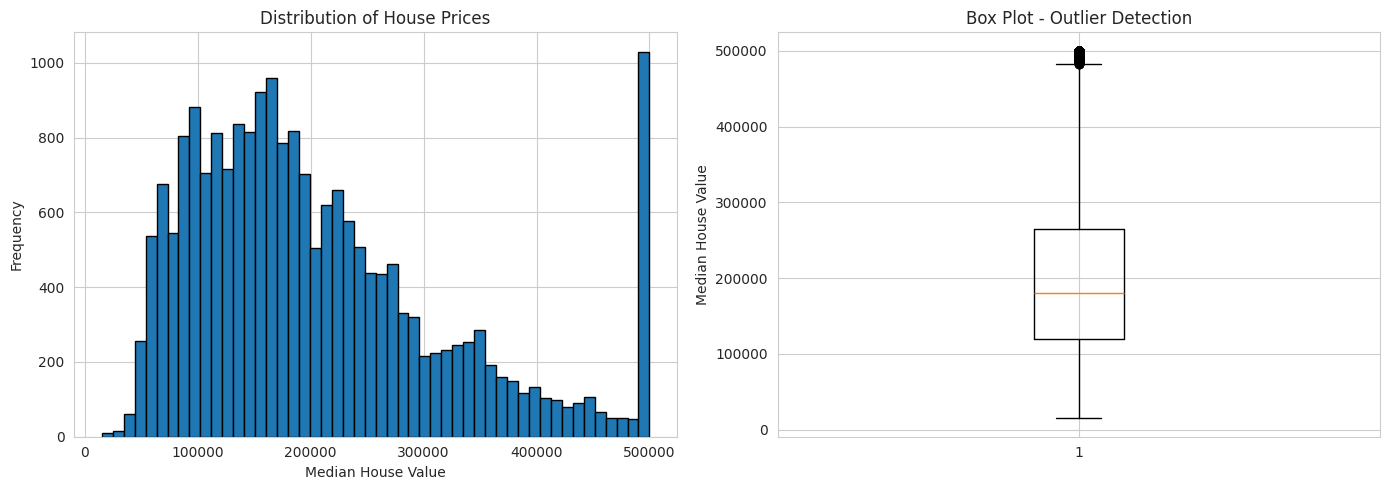

Skewness: 0.98


In [17]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['median_house_value'], bins=50, edgecolor='black')
axes[0].set_xlabel('Median House Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of House Prices')

# Box plot
axes[1].boxplot(df['median_house_value'])
axes[1].set_ylabel('Median House Value')
axes[1].set_title('Box Plot - Outlier Detection')

plt.tight_layout()
plt.show()

# Check skewness
print(f"Skewness: {df['median_house_value'].skew():.2f}")

Step 4: Explore Feature Relationships

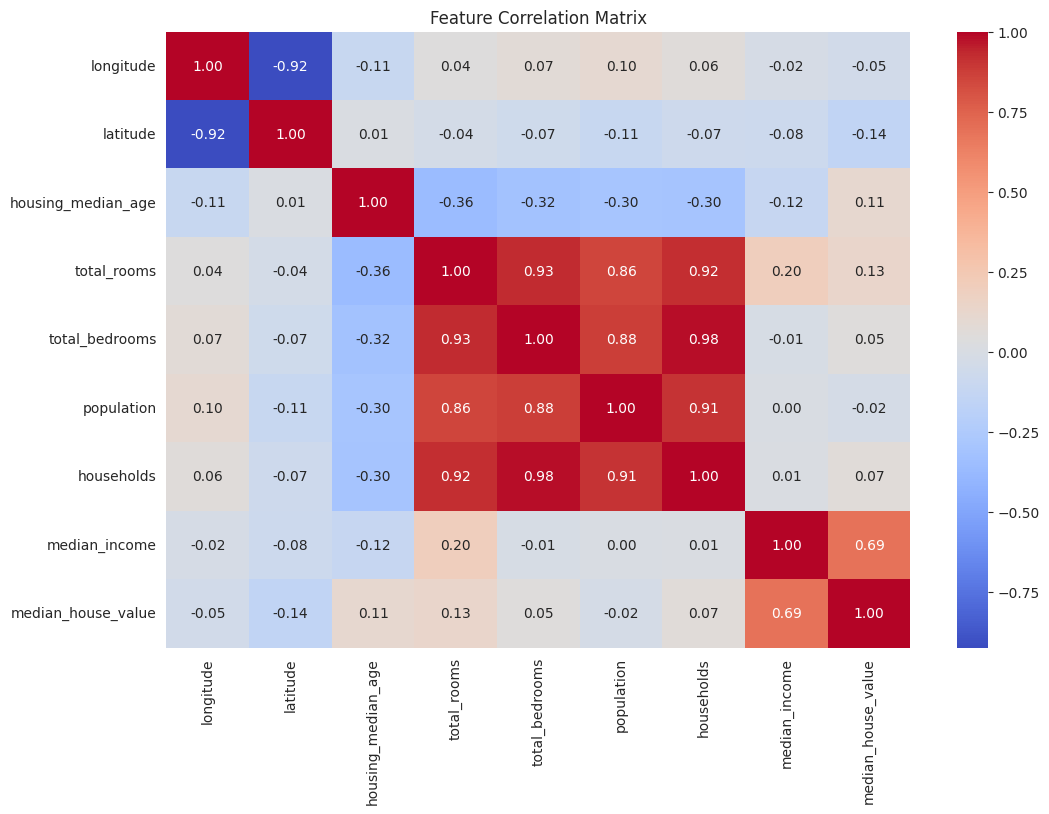


=== Correlations with House Value ===
median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


In [18]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
# Exclude non-numeric columns for correlation calculation
correlation = df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlations with target
target_corr = correlation['median_house_value'].sort_values(ascending=False)
print("\n=== Correlations with House Value ===")
print(target_corr)

Step 5: Scatter Plots for Key Features

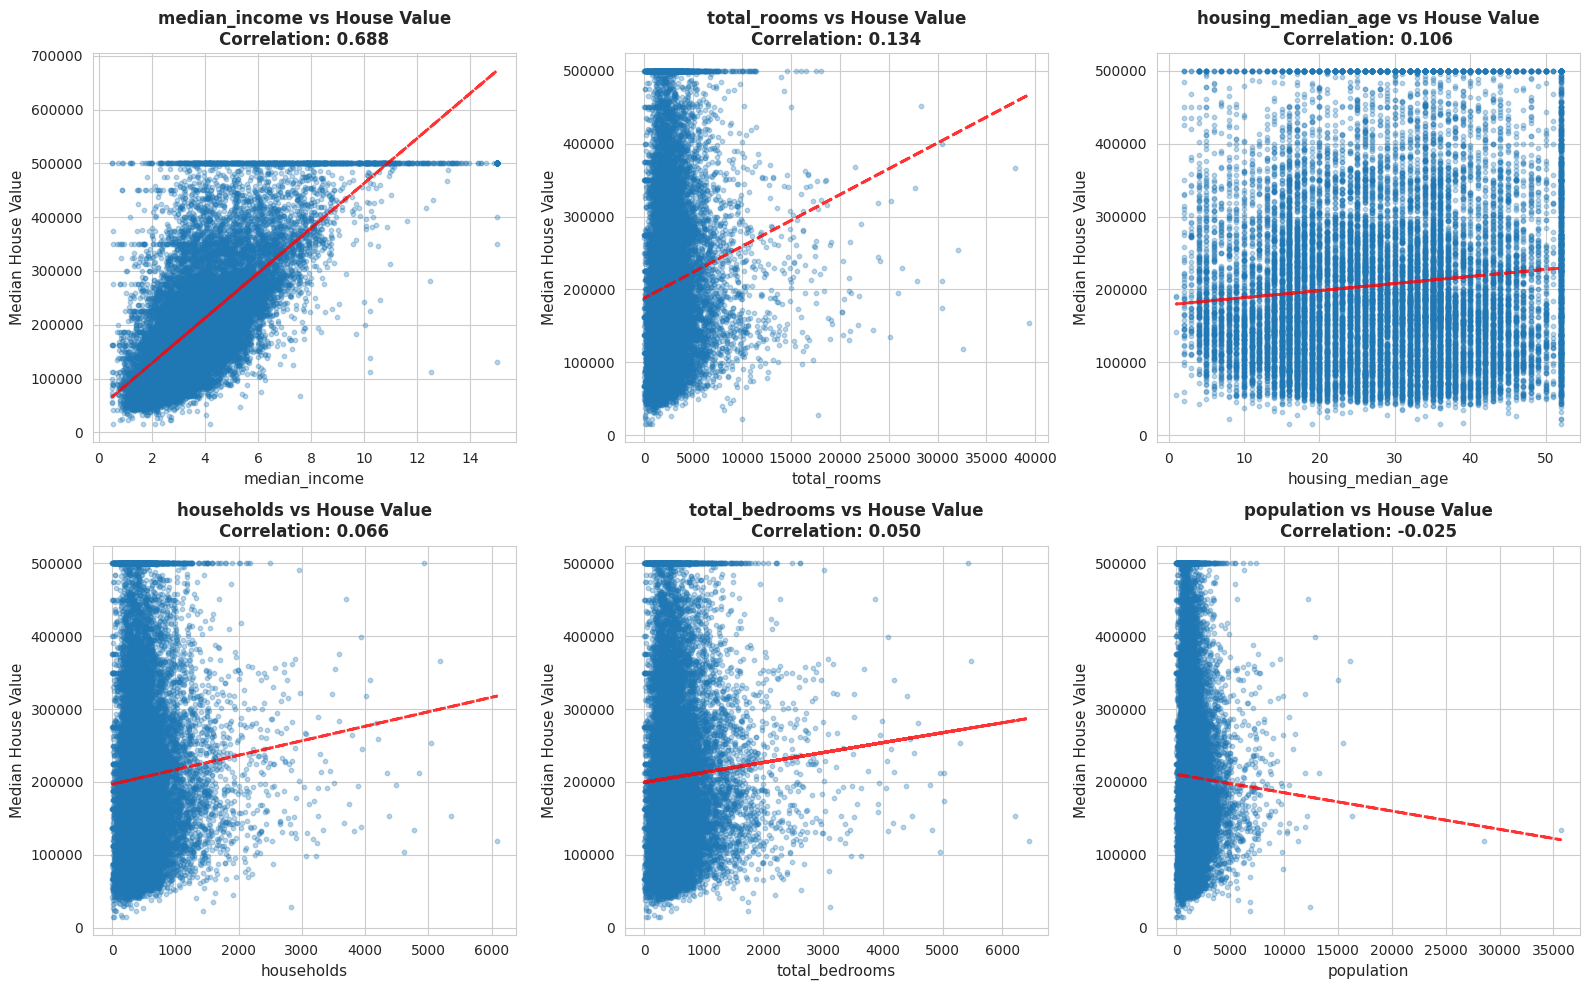

In [19]:
# Scatter plots of key features vs. target
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Select top correlated features
top_features = target_corr.head(7).index[1:]  # Exclude target itself

for idx, feature in enumerate(top_features[:6]):
    axes[idx].scatter(df[feature], df['median_house_value'], alpha=0.3, s=10)
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Median House Value', fontsize=11)
    axes[idx].set_title(f'{feature} vs House Value\nCorrelation: {target_corr[feature]:.3f}',
                       fontsize=12, fontweight='bold')

    # Add trend line
    z = np.polyfit(df[feature].dropna(), df['median_house_value'][df[feature].notna()], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

Step 6: Handle Missing Values

In [20]:
# @title Default title text
# Check missing values in detail
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing_Count': missing_data[missing_data > 0],
    'Percentage': missing_percent[missing_data > 0]
}).sort_values('Percentage', ascending=False)

print("=== Missing Data Analysis ===")
print(missing_df)

=== Missing Data Analysis ===
                Missing_Count  Percentage
total_bedrooms            207         1.0


Strategy for Housing Data:

In [21]:
# Handle missing values based on feature type
# For California housing, typically minimal missing data
# But let's be thorough

# Check if 'total_bedrooms' has missing values (common in this dataset)
if 'total_bedrooms' in df.columns and df['total_bedrooms'].isnull().sum() > 0:
    # Fill with median (robust to outliers)
    df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)
    print(" Filled 'total_bedrooms' with median")

# Drop rows with any remaining missing values (if < 1%)
if df.isnull().sum().sum() > 0:
    initial_rows = len(df)
    df.dropna(inplace=True)
    print(f" Dropped {initial_rows - len(df)} rows with missing values")

print(f"\nFinal dataset shape: {df.shape}")

 Filled 'total_bedrooms' with median

Final dataset shape: (20640, 10)


Step 7: Feature Engineering - Create New Features

In [22]:
# Create new meaningful features
print("Creating new features...")

# 1. Rooms per household
df['rooms_per_household'] = df['total_rooms'] / df['households']

# 2. Bedrooms per room (bedroom ratio)
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

# 3. Population per household (crowdedness)
df['population_per_household'] = df['population'] / df['households']

# 4. Log transformation for skewed features
# House values are often right-skewed, log helps normalize
df['log_median_income'] = np.log1p(df['median_income'])  # log(1+x) to handle zeros
df['log_population'] = np.log1p(df['population'])

# 5. Income squared (capture non-linear relationship)
df['income_squared'] = df['median_income'] ** 2

print(" Created 6 new features")
print("\nNew features:")
print(df[['rooms_per_household', 'bedrooms_per_room', 'population_per_household',
          'log_median_income', 'log_population', 'income_squared']].head())

Creating new features...
 Created 6 new features

New features:
   rooms_per_household  bedrooms_per_room  population_per_household  \
0             6.984127           0.146591                  2.555556   
1             6.238137           0.155797                  2.109842   
2             8.288136           0.129516                  2.802260   
3             5.817352           0.184458                  2.547945   
4             6.281853           0.172096                  2.181467   

   log_median_income  log_population  income_squared  
0           2.232720        5.777652       69.308955  
1           2.230165        7.784057       68.913242  
2           2.111110        6.208590       52.669855  
3           1.893579        6.326149       31.844578  
4           1.578195        6.338594       14.793254  


Step 8: Handle Categorical Variables (if any)

In [23]:
# Check for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")

# For California Housing, 'ocean_proximity' is categorical
if 'ocean_proximity' in df.columns:
    print("\nOcean Proximity Distribution:")
    print(df['ocean_proximity'].value_counts())

    # One-hot encoding
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
    print("\n One-hot encoded 'ocean_proximity'")

print(f"\nFinal feature count: {df.shape[1]}")

Categorical columns: ['ocean_proximity']

Ocean Proximity Distribution:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

 One-hot encoded 'ocean_proximity'

Final feature count: 19


Step 9: Handle Outliers

In [24]:
# Detect outliers using IQR method
def remove_outliers(df, column, lower_percentile=1, upper_percentile=99):
    """Remove outliers based on percentiles"""
    lower = df[column].quantile(lower_percentile / 100)
    upper = df[column].quantile(upper_percentile / 100)

    initial_len = len(df)
    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]
    removed = initial_len - len(df_clean)

    print(f"  {column}: Removed {removed} outliers (kept values between {lower:.2f} and {upper:.2f})")
    return df_clean

# Remove extreme outliers from key features
print("Removing outliers (keeping 1st to 99th percentile):")

df = remove_outliers(df, 'median_house_value', 1, 99)
df = remove_outliers(df, 'median_income', 1, 99)

print(f"\n Cleaned dataset shape: {df.shape}")

Removing outliers (keeping 1st to 99th percentile):
  median_house_value: Removed 199 outliers (kept values between 50000.00 and 500001.00)
  median_income: Removed 410 outliers (kept values between 1.11 and 10.62)

 Cleaned dataset shape: (20031, 19)


Step 10: Prepare Final Feature Set

In [25]:
# Separate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

print("=== Feature Matrix ===")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature names ({len(X.columns)}):")
print(list(X.columns))

=== Feature Matrix ===
Features (X): (20031, 18)
Target (y): (20031,)

Feature names (18):
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'log_median_income', 'log_population', 'income_squared', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


Session 3: Model Training & Evaluation
Step 11: Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Training set: 16024 samples
Test set: 4007 samples
Features: 18


Step 12: Feature Scaling (Important for Linear Models)


In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled (mean=0, std=1)")
print(f"\nExample - Original vs. Scaled (first feature):")
print(f"Original mean: {X_train.iloc[:, 0].mean():.2f}")
print(f"Scaled mean: {X_train_scaled[:, 0].mean():.2f}")
print(f"Original std: {X_train.iloc[:, 0].std():.2f}")
print(f"Scaled std: {X_train_scaled[:, 0].std():.2f}")

 Features scaled (mean=0, std=1)

Example - Original vs. Scaled (first feature):
Original mean: -119.59
Scaled mean: -0.00
Original std: 2.00
Scaled std: 1.00


Step 13: Train Linear Regression Model

In [28]:
from sklearn.linear_model import LinearRegression

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print(" Linear Regression model trained successfully!")

 Linear Regression model trained successfully!


Step 14: Evaluate Model Performance

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate and display regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {dataset_name} Performance ===")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"MAE:  ${mae:,.2f}")
    print(f"R² Score: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on both training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training Set")
test_metrics = evaluate_model(y_test, y_test_pred, "Test Set")


=== Training Set Performance ===
RMSE: $67,143.71
MAE:  $48,522.64
R² Score: 0.6382

=== Test Set Performance ===
RMSE: $64,940.44
MAE:  $47,561.73
R² Score: 0.6622


Step 15: Visualize Predictions

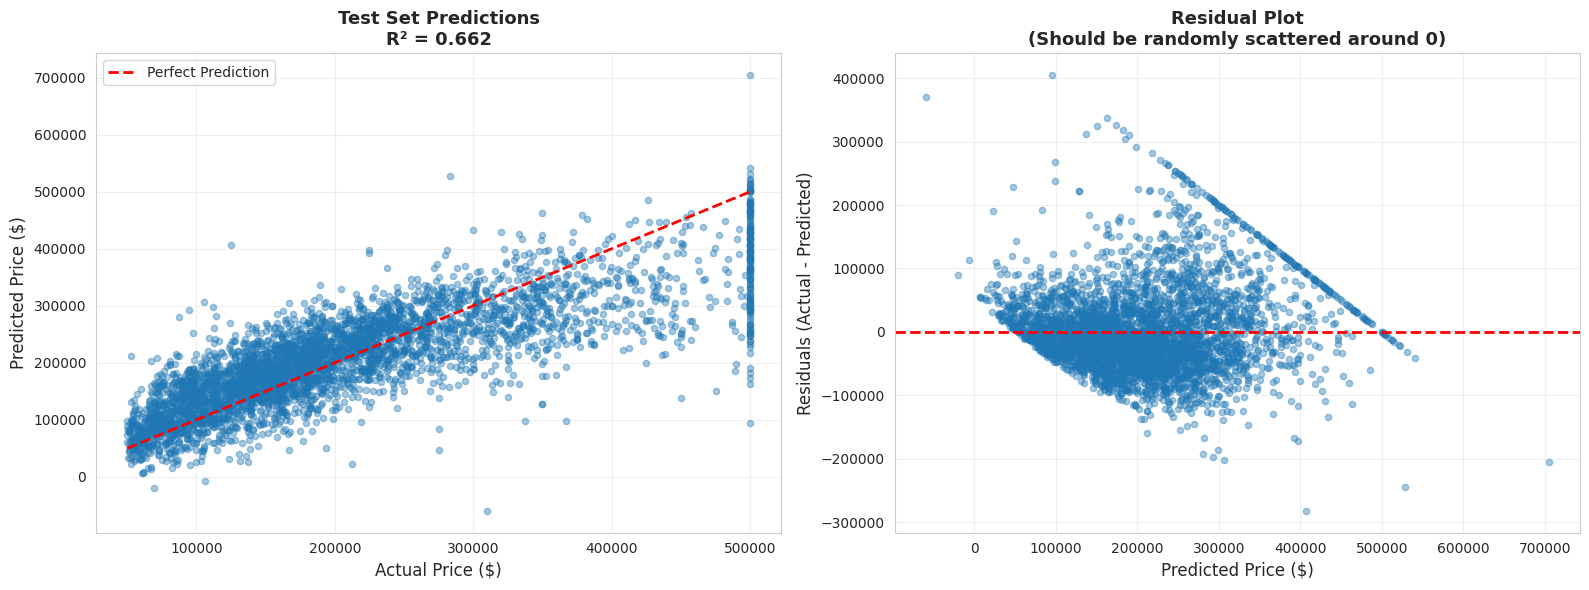

In [30]:
# Scatter plot: Predicted vs. Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test set predictions
axes[0].scatter(y_test, y_test_pred, alpha=0.4, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Test Set Predictions\nR² = {test_metrics["R2"]:.3f}',
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot (errors)
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.4, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot\n(Should be randomly scattered around 0)',
                 fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Step 16: Feature Importance Analysis


=== Top 10 Most Important Features ===
               Feature   Coefficient
         median_income 156754.992612
     log_median_income -55609.097849
              latitude -54824.341826
             longitude -54276.908418
            households  46794.434939
            population -41234.547814
        income_squared -30209.545715
        total_bedrooms  16912.220501
ocean_proximity_INLAND -16121.929348
    housing_median_age  14904.066635


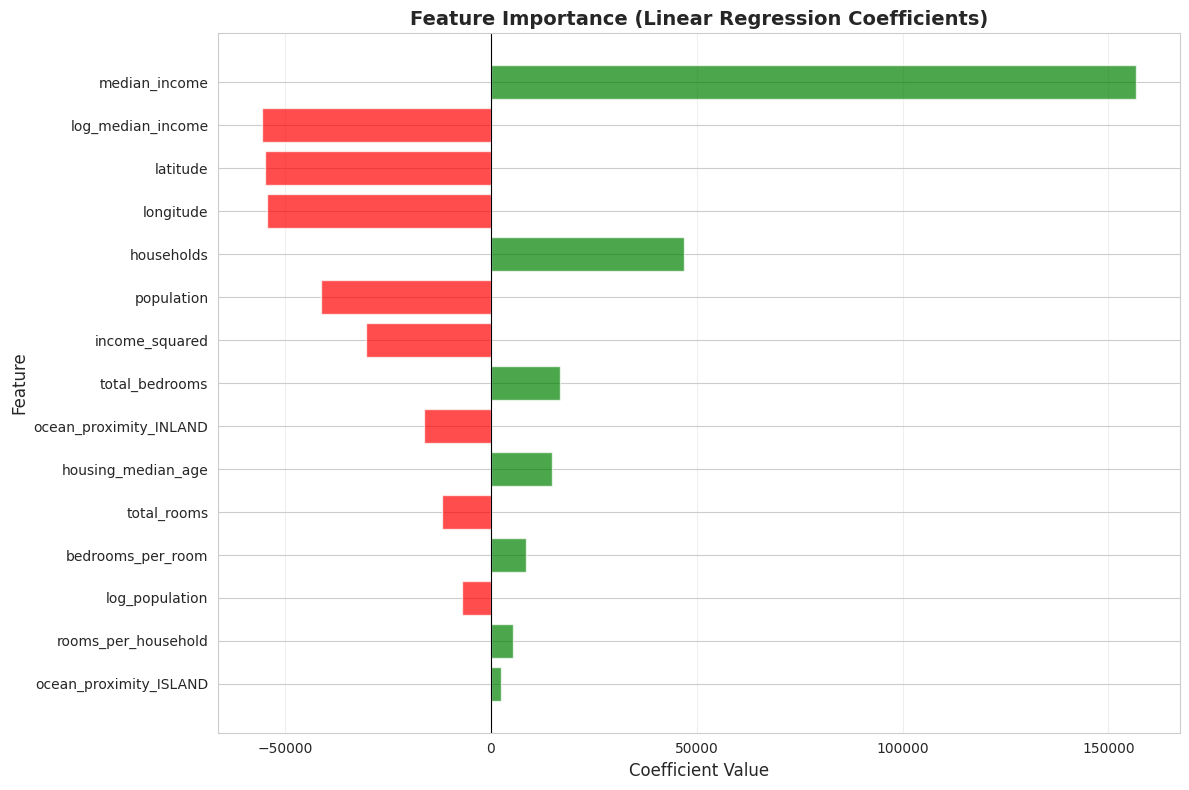

In [31]:
# Linear Regression coefficients show feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 8))
top_n = 15
top_features = feature_importance.head(top_n)

# Use absolute values for plotting the bar lengths
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(top_n), abs(top_features['Coefficient']), color=colors, alpha=0.7)
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance (Linear Regression Coefficients - Absolute Value)',
         fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Step 17: Cross-Validation for Robust Evaluation

In [32]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
print("\n=== Cross-Validation (5 folds) ===")

# Negative MSE (sklearn convention)
cv_mse = -cross_val_score(lr_model, X_train_scaled, y_train,
                           cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(cv_mse)

cv_r2 = cross_val_score(lr_model, X_train_scaled, y_train,
                        cv=5, scoring='r2')

print(f"RMSE per fold: {cv_rmse}")
print(f"Mean RMSE: ${cv_rmse.mean():,.2f} (±${cv_rmse.std():,.2f})")
print(f"\nR² per fold: {cv_r2}")
print(f"Mean R²: {cv_r2.mean():.4f} (±{cv_r2.std():.4f})")

# Compare with test set
print(f"\nTest set RMSE: ${test_metrics['RMSE']:,.2f}")
print(f"Test set R²: {test_metrics['R2']:.4f}")


=== Cross-Validation (5 folds) ===
RMSE per fold: [68260.08271725 68071.21918112 68700.41780671 67336.80349283
 66384.3203972 ]
Mean RMSE: $67,750.57 (±$812.71)

R² per fold: [0.63622715 0.61474101 0.6135571  0.64190154 0.64938478]
Mean R²: 0.6312 (±0.0145)

Test set RMSE: $64,940.44
Test set R²: 0.6622


Step 18: Compare with Ridge & Lasso Regression

In [33]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression (L2 regularization)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)

# Lasso Regression (L1 regularization)
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)

# Evaluate all three models
print("\n" + "="*70)
print("MODEL COMPARISON: Linear Regression vs Ridge vs Lasso")
print("="*70)

models = {
    'Linear Regression': y_test_pred,
    'Ridge Regression': ridge_pred,
    'Lasso Regression': lasso_pred
}

comparison_results = []

for name, predictions in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    comparison_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

    print(f"\n{name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*70)
print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON: Linear Regression vs Ridge vs Lasso

Linear Regression:
  RMSE: $64,940.44
  MAE:  $47,561.73
  R²:   0.6622

Ridge Regression:
  RMSE: $64,945.35
  MAE:  $47,559.70
  R²:   0.6622

Lasso Regression:
  RMSE: $64,952.40
  MAE:  $47,559.52
  R²:   0.6621

            Model         RMSE          MAE       R²
Linear Regression 64940.440059 47561.732720 0.662235
 Ridge Regression 64945.354253 47559.696013 0.662184
 Lasso Regression 64952.401164 47559.517885 0.662110


Step 19: Visualize Model Comparison

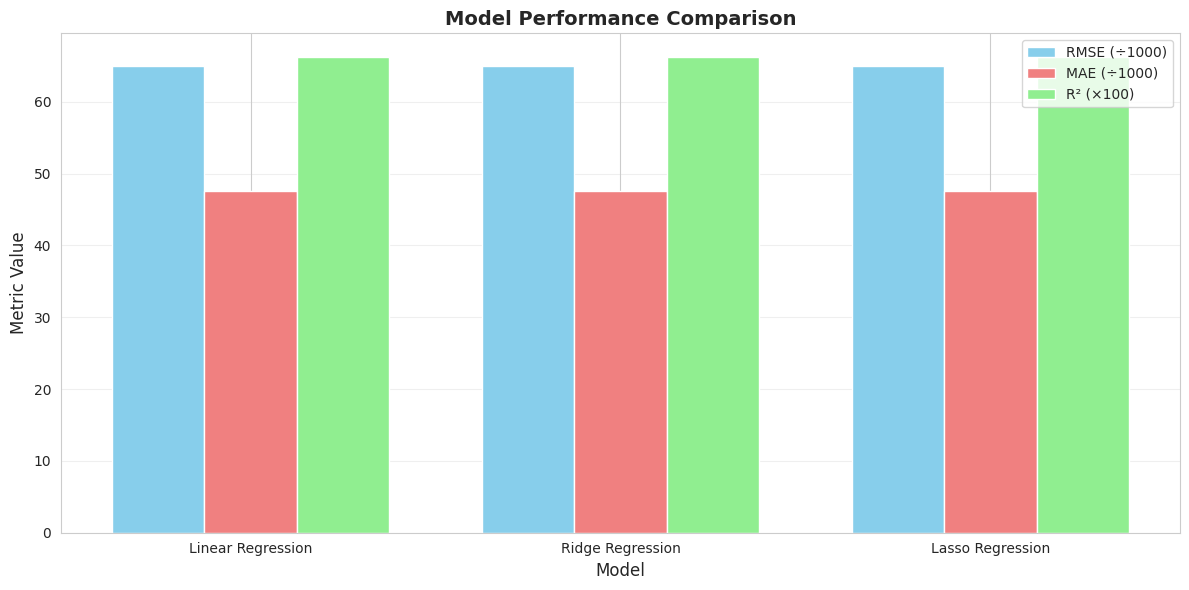

In [34]:
# Bar chart comparing models
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['RMSE']/1000, width, label='RMSE (÷1000)', color='skyblue')
ax.bar(x, comparison_df['MAE']/1000, width, label='MAE (÷1000)', color='lightcoral')
ax.bar(x + width, comparison_df['R²']*100, width, label='R² (×100)', color='lightgreen')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Step 20: Hyperparameter Tuning for Ridge/Lasso

In [35]:
from sklearn.model_selection import GridSearchCV

# Tune Ridge
print("Tuning Ridge Regression...")
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params,
                          cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)

print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV RMSE: ${np.sqrt(-ridge_grid.best_score_):,.2f}")

# Tune Lasso
print("\nTuning Lasso Regression...")
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(random_state=42), lasso_params,
                          cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)

print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best CV RMSE: ${np.sqrt(-lasso_grid.best_score_):,.2f}")

# Test best models
ridge_best_pred = ridge_grid.best_estimator_.predict(X_test_scaled)
lasso_best_pred = lasso_grid.best_estimator_.predict(X_test_scaled)

print("\n=== Tuned Model Performance on Test Set ===")
print(f"Ridge RMSE: ${np.sqrt(mean_squared_error(y_test, ridge_best_pred)):,.2f}")
print(f"Lasso RMSE: ${np.sqrt(mean_squared_error(y_test, lasso_best_pred)):,.2f}")

Tuning Ridge Regression...
Best Ridge alpha: 0.001
Best CV RMSE: $67,755.45

Tuning Lasso Regression...
Best Lasso alpha: 0.001
Best CV RMSE: $67,765.96

=== Tuned Model Performance on Test Set ===
Ridge RMSE: $64,940.44
Lasso RMSE: $64,951.20
